In [22]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [23]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/picture_2.png'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1633, 2677, 3)


In [24]:
# 구글에서 Tensorflow V1으로 작성한 DeepLab모델 구조를 그대로 가져와 활용
# DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read()) # tf.compat.v1 - Tensorflow V2에서 V1코드와 모델 구조를 활용할 수 있도록 제공
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)
        
    
    # preprocess()는 전처리 하는 함수
    
    # 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리
    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height) # 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB) # OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
        img_input = resized_rgb
        return img_input
    
    # 실제로 세그멘테이션 하는 함수    
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [25]:
import tensorflow as tf
import tarfile
# 구글에서 제공하는 파일을 다운로드
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [26]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

# cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다.
# seg_map.max() : 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻

(1633, 2677, 3) (312, 513, 3) 15


In [27]:
# DeepLab 에서 제공하는 라벨 종류는 아래와 같습니다.
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
               'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
len(LABEL_NAMES)

21

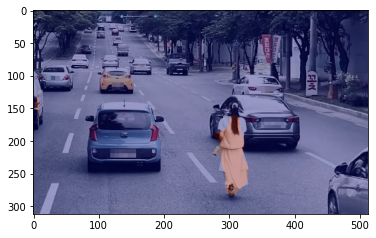

In [28]:
# 사람 라벨을 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)  # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max())  # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

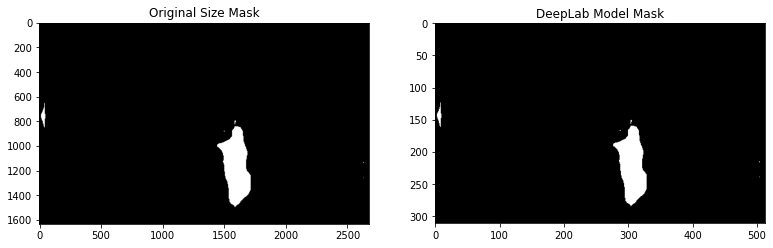

In [29]:
# interpolation(보간법) : 이미지의 크기(scaling)를 변경하는 하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)  

# 결과적으로 img_mask_up은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다.
# 확실한 경계를 다시 정하기 위해 중간값이 128을 기준으로 임계값(threshold)을 설정합니다.
# 128 이하의 값은 0으로, 128 이상의 값은 255로 만들어준다.
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(13,13))

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

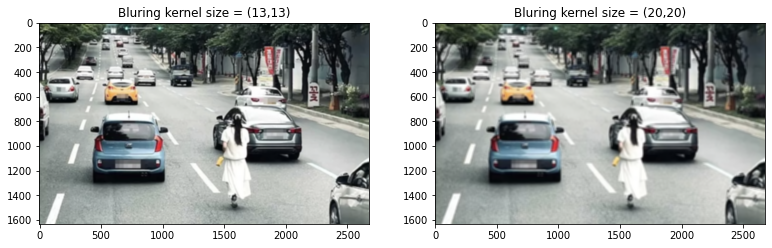

In [30]:
# blur() 함수 이용
img_orig_blur = cv2.blur(img_orig, (13,13))  # (13,13)은 blurring  kernel size를 뜻합니다. 
img_orig_blur2 = cv2.blur(img_orig, (20,20))  # blurring  kernel size를 (20,20)으로 만들어서 (13,13)과 차이를 확인해봅니다. 


plt.figure(figsize=(13,13))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
ax.set_title('Bluring kernel size = (13,13)')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
ax.set_title('Bluring kernel size = (20,20)')

plt.show()

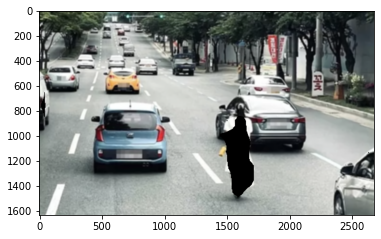

In [31]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)  # bitwise_not 함수를 이용하면 이미지가 반전된다.(배경은 255, 사람은 0)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  # 반전된 세그멘테이션 결과를 이용해 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있게 된다.

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

plt.show()

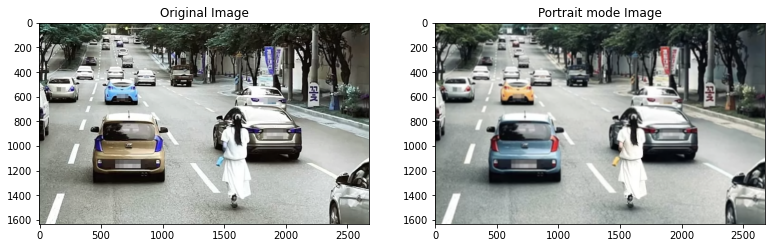

In [32]:
# 배경 이미지와 인물 이미지를 합쳐준다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)  # 마스크에서 255인 부분(사람)은 img_orig, 아닌 부분은 img_bg_blur 를 사용

plt.figure(figsize=(13,13))
plt.subplot(1,2,1)
plt.imshow(img_orig)
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Portrait mode Image')

plt.show()